In [12]:
# Import everything that we are going to need
import pandas as pd
import geopandas
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import scipy.interpolate

In [4]:
#Date 15/07/2007
#Terra MODIS
Terradata1030Z=xr.open_dataset('/neodc/eustace/data/satellite_skin_temperature/UOL/land/MODIS_Terra/L2/GT_MOG_2P/v2.1/2007/07/15/GT_SSD-L2-MOGSV_LST_2-20070715_103000-CUOL-0.01X0.01-V2.1.nc')
Terradata2140Z=xr.open_dataset('/neodc/eustace/data/satellite_skin_temperature/UOL/land/MODIS_Terra/L2/GT_MOG_2P/v2.1/2007/07/15/GT_SSD-L2-MOGSV_LST_2-20070715_214000-CUOL-0.01X0.01-V2.1.nc')

#Aqua MODIS
Aquadata0105Z=xr.open_dataset('/neodc/eustace/data/satellite_skin_temperature/UOL/land/MODIS_Aqua/L2/GT_MYG_2P/v2.1/2007/07/15/GT_SSD-L2-MYGSV_LST_2-20070715_010500-CUOL-0.01X0.01-V2.1.nc')
Aquadata1215Z=xr.open_dataset('/neodc/eustace/data/satellite_skin_temperature/UOL/land/MODIS_Aqua/L2/GT_MYG_2P/v2.1/2007/07/15/GT_SSD-L2-MYGSV_LST_2-20070715_121500-CUOL-0.01X0.01-V2.1.nc')


In [6]:
#Change from array to dataframe
df_Terradata1030Z = Terradata1030Z.to_dataframe()
df_Terradata2140Z = Terradata2140Z.to_dataframe()
df_Aquadata0105Z = Aquadata0105Z.to_dataframe()
df_Aquadata1215Z = Aquadata1215Z.to_dataframe()

In [62]:
#select a subset (Area containing Milan city centre and 39km around it, taken from Anniballe 2014)
#45.29<lat<45.64, 8.91<lon<9.42
subset_Terradata1030Z= df_Terradata1030Z[(df_Terradata1030Z.lat >45.29) & (df_Terradata1030Z.lat < 45.65) & (df_Terradata1030Z.lon > 8.91) & (df_Terradata1030Z.lon < 9.42)]

In [63]:
subset_Terradata1030Z["LST"].mean()

314.22214

In [64]:
#converting from dataframe to array
#lon= subset_Terradata1030Z["lon"].values
#lat= subset_Terradata1030Z["lat"].values
#LST= subset_Terradata1030Z["LST"].values


In [65]:
#Need to project the lat and lon coordinates onto a grid
#start by importing the packages we need to do this
import shapely.geometry
import pyproj
from shapely.geometry import Point, LineString, Polygon
from cartopy import crs as ccrs

In [66]:
#Change the coordinate reference system
#lat and lon coordinates are not accurate as they are distorted by the shape of the map
subset_Terradata1030Z_df_geometry = [Point(xy) for xy in zip(subset_Terradata1030Z.lon, subset_Terradata1030Z.lat)]

gdf = geopandas.GeoDataFrame(subset_Terradata1030Z, geometry=subset_Terradata1030Z_df_geometry)
gdf.crs= {'init': 'epsg:4326', 'no_defs': True}

In [67]:
gdf2 = gdf.to_crs(epsg=3003) #epsg 3003 is mainland italy, units in m, cartesian 2D axis

In [ ]:
#####NOT USED- probably delete
##################################################################
# Set up projections
p_ll = pyproj.Proj(init='epsg:4326')
p_mt = pyproj.Proj(init='epsg:3857') # metric; same as EPSG:900913

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((8.0, 45.0))
ne = shapely.geometry.Point((10.0, 46.0))

stepsize = 1000 # 1 km grid step size

# Project corners to target projection
transformed_sw = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform NW point to 3857
transformed_ne = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for SE
###################################################################


In [45]:
#####NOT USED -probably delete
##################################################################
# Iterate over 2D area
gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

with open('testout.csv', 'w') as of:
    of.write('lon;lat\n')
    for p in gridpoints:
        of.write('{:f};{:f}\n'.format(p.x, p.y))
###################################################################

In [54]:
#for x in range(len(gridpoints)): 
#    print (gridpoints[x])

In [68]:
df1= pd.DataFrame(gdf2)

In [70]:
#Extract the x and y coordinates 
x_points = gdf2['geometry'].x
y_points = gdf2['geometry'].y

In [71]:
#Add the extracted coordinates to dataframe
gdf2['xpoints'] = x_points
gdf2['ypoints'] = y_points

In [168]:
#gdf2

In [73]:
#Determine the origin
origin_x = min(gdf2.xpoints)
origin_y = min(gdf2.ypoints)

In [74]:
#Subtract the orgin from the points
gdf2['x_points'] = gdf2['xpoints'] - origin_x
gdf2['y_points'] = gdf2['ypoints'] - origin_y

In [75]:
#Drop the xpoints and ypoints columns as they are no longer needed
gdf2 = gdf2.drop('xpoints', axis = 1)
gdf2 = gdf2.drop('ypoints', axis = 1)

In [76]:
#Check points by plotting
#specify x,y,LSTs
x= gdf2.x_points
y= gdf2.y_points
LST = gdf2.LST

In [82]:
#Check points by plotting
#get the points into the correct format
X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), LST, (X,Y), method='nearest')

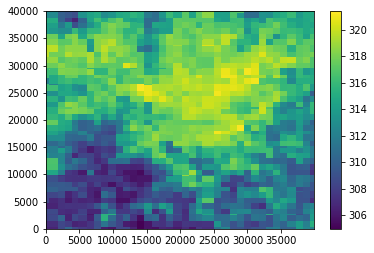

In [126]:
#Make plot
#Colour mesh plot
plt.pcolormesh(X,Y,Z)
plt.colorbar()

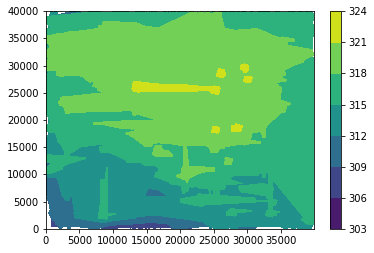

In [125]:
#Make plot
#Contour plot
plt.contourf(X,Y,Z,levels = 5)
plt.colorbar()

In [94]:
Z

array([[312.72998, 312.72998, 312.72998, ..., 314.91   , 314.91   ,
        314.91   ],
       [315.09   , 315.09   , 315.09   , ..., 314.58   , 315.07   ,
        315.07   ],
       [314.16   , 314.16   , 314.16   , ..., 314.58   , 314.58   ,
        314.58   ],
       ...,
       [308.59   , 308.59   , 308.3    , ..., 313.9    , 313.9    ,
        313.9    ],
       [307.08   , 307.08   , 307.08   , ..., 315.34   , 315.34   ,
        315.34   ],
       [306.62   , 306.62   , 306.62   , ..., 312.16998, 312.16998,
        312.16998]], dtype=float32)

In [95]:
#Take a look at QC flags
QC = gdf2.QC

In [98]:
#Apply the function to the QC list to check bytes 1 and 2. Then append this new list onto our data frame. 
#first off all define the functions

#function to check the status of a byte on the QC control
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag


In [112]:
#Apply to function to QC
QC2 = np.array([quality_control(int(i)) for i in QC])

In [115]:
#Now need to add this QC2 flag onto the dataset
gdf2['QC_2'] = QC2

In [118]:
#Look at the points which are not useable based on the QC flag
#first grid the QC_2 flag
QC_2 = gdf2.QC_2
QC_Z = scipy.interpolate.griddata((x, y), QC_2, (X,Y), method='nearest')

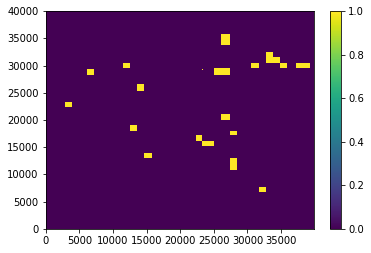

In [123]:
#Then plot 
plt.pcolormesh(X,Y,QC_Z)
plt.colorbar()

In [13]:
#Now need to apply a mask to the urban area and poor quality pixels
#so, mask out where QC_2 = 1 and using a land cover map
#first need to load up the land cover use data
LULC_ds=xr.open_dataset('/badc/quest/data/qesdi/external/modis/MCD12Q1_10min/MODIS_classification_IGBP.nc')

In [17]:
LULC_ds.index

<xarray.DataArray 'index' (index: 16)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
Dimensions without coordinates: index

In [204]:
#latitude are only coordinates, want to have them as data variabes so the can be used in analysis
#get 2 data arrays containing latitude and longitude
latitude = LULC_ds['latitude']
longitude = LULC_ds['longitude']
#index = LULC_ds['index']

In [205]:
#Add these in as variables in the dataset
LULC_ds['lat'] = latitude
LULC_ds['lon'] = longitude
#LULC_ds['index'] = index

In [206]:
#Change from array to dataframe
LULC_df = LULC_ds.to_dataframe()

In [207]:
#select a subset (Area containing Milan city centre and 39km around it, taken from Anniballe 2014)
#45.29<lat<45.64, 8.91<lon<9.42
subset_LULC_df= LULC_df[(LULC_df.lat >45.29) & (LULC_df.lat < 45.65) & (LULC_df.lon > 8.91) & (LULC_df.lon < 9.42)]

In [211]:
subset_LULC_df

landtype        lat       lon
index latitude  longitude                               
0     45.583332 8.916672   0.000000  45.583332  8.916672
                9.083344   0.000000  45.583332  9.083344
                9.250000   0.000000  45.583332  9.250000
                9.416672   0.000000  45.583332  9.416672
      45.416664 8.916672   0.000000  45.416664  8.916672
                9.083344   0.000000  45.416664  9.083344
                9.250000   0.000000  45.416664  9.250000
                9.416672   0.000000  45.416664  9.416672
1     45.583332 8.916672   0.000000  45.583332  8.916672
                9.083344   0.000000  45.583332  9.083344
                9.250000   0.000000  45.583332  9.250000
                9.416672   0.000000  45.583332  9.416672
      45.416664 8.916672   0.000000  45.416664  8.916672
                9.083344   0.000000  45.416664  9.083344
                9.250000   0.000000  45.416664  9.250000
                9.416672   0.000000  45.416664  9.416672
2     45.583332 8.916672   0.000000  45.583332  8.916672
                9.083344   0.000000  45.583332  9.083344
                9.250000   0.000000  45.583332  9.250000
                9.416672   0.000000  45.583332  9.416672
      45.416664 8.916672   0.000000  45.416664  8.916672
                9.083344   0.000000  45.416664  9.083344
                9.250000   0.000000  45.416664  9.250000
                9.416672   0.000000  45.416664  9.416672
3     45.583332 8.916672   0.000000  45.583332  8.916672
                9.083344   0.000000  45.583332  9.083344
                9.250000   0.000000  45.583332  9.250000
                9.416672   0.000000  45.583332  9.416672
      45.416664 8.916672   0.003568  45.416664  8.916672
                9.083344   0.000000  45.416664  9.083344
...                             ...        ...       ...
12    45.583332 9.250000   0.857143  45.583332  9.250000
                9.416672   0.334821  45.583332  9.416672
      45.416664 8.916672   0.146298  45.416664  8.916672
                9.083344   0.449778  45.416664  9.083344
                9.250000   0.525378  45.416664  9.250000
                9.416672   0.065004  45.416664  9.416672
13    45.583332 8.916672   0.014286  45.583332  8.916672
                9.083344   0.006256  45.583332  9.083344
                9.250000   0.033036  45.583332  9.250000
                9.416672   0.049107  45.583332  9.416672
      45.416664 8.916672   0.115076  45.416664  8.916672
                9.083344   0.039111  45.416664  9.083344
                9.250000   0.026714  45.416664  9.250000
                9.416672   0.204809  45.416664  9.416672
14    45.583332 8.916672   0.000000  45.583332  8.916672
                9.083344   0.000000  45.583332  9.083344
                9.250000   0.000000  45.583332  9.250000
                9.416672   0.000000  45.583332  9.416672
      45.416664 8.916672   0.000000  45.416664  8.916672
                9.083344   0.000000  45.416664  9.083344
                9.250000   0.000000  45.416664  9.250000
                9.416672   0.000000  45.416664  9.416672
15    45.583332 8.916672   0.000000  45.583332  8.916672
                9.083344   0.000000  45.583332  9.083344
                9.250000   0.000000  45.583332  9.250000
                9.416672   0.000000  45.583332  9.416672
      45.416664 8.916672   0.000000  45.416664  8.916672
                9.083344   0.000000  45.416664  9.083344
                9.250000   0.000000  45.416664  9.250000
                9.416672   0.000000  45.416664  9.416672

[128 rows x 3 columns]

In [175]:
#Check points by plotting
#get the points into the correct format
x_lu = subset_LULC_df.lon
y_lu = subset_LULC_df.lat
LT_lu = subset_LULC_df.landtype

X_lu,Y_lu = np.meshgrid(x_lu,y_lu)
Z_lu = scipy.interpolate.griddata((x_lu, y_lu), LT_lu, (X_lu,Y_lu), method='nearest')

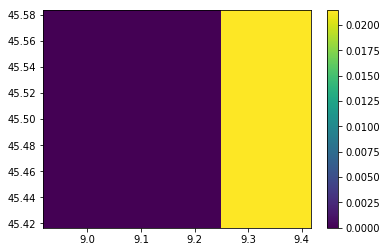

In [176]:
#Make plot
#Colour mesh plot
plt.pcolormesh(X_lu,Y_lu, Z_lu)
plt.colorbar()

In [18]:
 dada = xr.open_dataset('/neodc/esacci/land_cover/data/land_cover_maps/v2.0.7/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2007-v2.0.7b.nc')

In [20]:
dada.lccs_class

<xarray.DataArray 'lccs_class' (lat: 64800, lon: 129600)>
[8398080000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.99861 89.995834 89.99306 ... -89.995834 -89.99861
  * lon      (lon) float32 -179.99861 -179.99583 ... 179.99583 179.99861
Attributes:
    long_name:            Land cover class defined in LCCS
    standard_name:        land_cover_lccs
    flag_values:          [   0   10   11   12   20   30   40   50   60   61 ...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    valid_min:            1
    valid_max:            220
    ancillary_variables:  processed_flag current_pixel_state observation_coun...